**写在前面**：本节内容是 [Datawhale三月的组队学习 - 集成学习（上）- CH2-机器学习基础模型回顾 -【Task2 掌握基本的回归模型】](https://github.com/datawhalechina/team-learning-data-mining/blob/master/EnsembleLearning/CH2-%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E5%9F%BA%E7%A1%80%E6%A8%A1%E5%9E%8B%E5%9B%9E%E9%A1%BE/%E7%AC%AC%E4%BA%8C%E7%AB%A0%EF%BC%9A%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E5%9F%BA%E7%A1%80.ipynb) 的学习笔记，对应notebook的2.1(1),(2),(3)节，学习周期3天

## 导入库和数据

In [270]:
import pandas as pd
from sklearn import datasets
from sklearn.metrics import *
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from pygam import LinearGAM
import xgboost

In [9]:
# boston数据集作为本笔记的实验数据
boston = datasets.load_boston()
X = boston.data
y = boston.target
features = boston.feature_names
boston_data = pd.DataFrame(X,columns=features)
boston_data["Price"] = y

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)

In [15]:
# 使用xgboost的回归模型作为实验模型
model = xgboost.XGBRegressor()
model.fit(X=X_train, y=y_train)
y_pred = model.predict(X_test)

## Day 1

### 度量模型性能的指标
参考资料：
- [【从零开始学机器学习12】MSE、RMSE、R2_score](https://blog.csdn.net/wade1203/article/details/98477034)

#### MSE均方误差
$$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.$$
- 去除了评价模型性能时样本数量带来的影响，但改变了量纲。且量纲不同时，难以衡量模型效果好坏。  
- 值越小模型性能越好。  
**注**：RMSE通过对MSE开方使得量纲不变。

##### sklearn调用

In [16]:
mean_squared_error(y_true=y_test, y_pred=y_pred)

8.892444740491776

##### 简单实现

In [26]:
def sample_MSE(y_true,y_pred):
    return sum((y_pred - y_true)**2)/len(y_pred)
sample_MSE(y_true=y_test, y_pred=y_pred)

8.892444740491776

#### MAE平均绝对误差
$$\text{MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|$$
- 另一种避免误差出现正负相消的方式，去除了评价模型性能时样本数量和量纲带来的的影响。且量纲不同时，难以衡量模型效果好坏。  
- 值越小模型性能越好。

##### sklearn调用

In [27]:
mean_absolute_error(y_true=y_test, y_pred=y_pred)

2.0381042082478684

##### 简单实现

In [28]:
def sample_MAE(y_true,y_pred):
    return sum(abs(y_pred - y_true))/len(y_pred)
sample_MAE(y_true=y_test, y_pred=y_pred)

2.0381042082478684

#### $R^2$决定系数
$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$
- 通过参照均值模型评价模型性能。和样本数量、量纲无关。
- 越接近1说明模型越好。小于0说明模型比均值模型差。出现这种情况，通常是模型本身不是线性关系的。
- 可改写为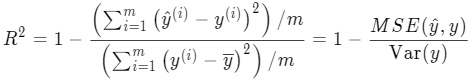

##### sklearn调用

In [34]:
r2_score(y_true=y_test, y_pred=y_pred)

0.8450080653253479

##### 简单实现

In [30]:
def sample_r2(y_true, y_pred):
    return 1 - sum((y_true-y_pred)**2)/sum((y_true-y_true.mean())**2)
sample_r2(y_true=y_test, y_pred=y_pred)

0.845008065325348

In [33]:
def other_sample_r2(y_true, y_pred):
    var = np.var(y_true)
    mse = sample_MSE(y_true=y_true, y_pred=y_pred)
    return 1 - mse/var
other_sample_r2(y_true=y_test, y_pred=y_pred)

0.845008065325348

#### 解释方差得分
$$explained\_{}variance(y, \hat{y}) = 1 - \frac{Var\{ y - \hat{y}\}}{Var\{y\}}$$
- 解释回归模型的方差得分.
- 其值取值范围是[0,1]，越接近于1说明自变量越能解释因变量的方差变化，值越小说明效果越差。

##### sklearn调用

In [35]:
explained_variance_score(y_true=y_test, y_pred=y_pred)

0.8454982194592924

##### 简单实现

In [37]:
def sample_explained_variance(y_true, y_pred):
    return 1 - np.var(y_true-y_pred)/np.var(y_true)
sample_explained_variance(y_true=y_test, y_pred=y_pred)

0.8454982194592924

### 线性回归模型

#### 线性回归LinearRegression
1. 最小二乘估计
$$ w=\cfrac{\sum_{i=1}^{m}y_i(x_i-\bar{x})}{\sum_{i=1}^{m}x_i^2-\cfrac{1}{m}(\sum_{i=1}^{m}x_i)^2} $$
$$b=\cfrac{1}{m}\sum_{i=1}^{m}(y_i-wx_i)$$
[变换]：$ \cfrac{1}{m}(\sum_{i=1}^{m}x_i)^2=\bar{x}\sum_{i=1}^{m}x_i $
2. 几何求解
3. 极大似然估计

参考资料：
- [南瓜书-第3章-3.10](https://datawhalechina.github.io/pumpkin-book/#/chapter3/chapter3?id=_310)

##### sklearn调用

In [40]:
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

In [109]:
print('w:\t',LR.coef_)
print('b:\t',LR.intercept_)
print('MSE:\t',mean_squared_error(y_test, y_pred))

w:	 [-1.14100684e-01  5.00445776e-02  1.62718524e-02  2.84846628e+00
 -2.08336584e+01  3.82436128e+00  1.71500717e-02 -1.45218637e+00
  2.83841761e-01 -1.02219978e-02 -9.93602309e-01  9.64704883e-03
 -5.46099073e-01]
b:	 37.38654384422135
MSE:	 17.932496480152306


##### 简单实现
class写法是现学的。。看着奇怪的话莫怪。。

In [235]:
class sample_LR:
    def __init__(self):
        pass

    def fit(self, X_train, y_train):
        X = np.c_[X_train, np.ones([X_train.shape[0], 1])]  # X的最后一个元素置1
        W = np.linalg.inv(X.T @ X) @ X.T @ y_train # 对应西瓜书公式(3.11)
        self.W = W # 闭式解包括w和b
        self.w = self.W[:-1]
        self.b = self.W[-1]

    def predict(self, X_test):
        X = np.c_[X_test, np.ones([X_test.shape[0], 1])] # X的最后一个元素置1
        return X @ self.W

In [236]:
my_LR = sample_LR()
my_LR.fit(X_train=X_train, y_train=y_train)
y_pred = my_LR.predict(X_test=X_test)

In [237]:
print('w:\t',my_LR.w)
print('b:\t',my_LR.b)
print('MSE:\t',mean_squared_error(y_test, y_pred))

w:	 [-1.14100684e-01  5.00445776e-02  1.62718524e-02  2.84846628e+00
 -2.08336584e+01  3.82436128e+00  1.71500717e-02 -1.45218637e+00
  2.83841761e-01 -1.02219978e-02 -9.93602309e-01  9.64704883e-03
 -5.46099073e-01]
b:	 37.38654384423745
MSE:	 17.93249648015395


##### 小记
- 一开始搞错了，用一元线性回归的闭式解在做，不出意外地错的很离谱。。折腾了好久才发现，长记性了。  
- 然后极大似然估计没整明白，对我现在来说有点超纲。。这学期学明白了再弄这块吧

### 线性回归推广

#### 多项式回归
体现因变量和特征的非线性关系  
参考资料：
- [多项式回归示例（sklearn实现）
](https://blog.csdn.net/alionsss/article/details/87635685)
- [sklearn.preprocessing.PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html?highlight=polynomialfeatures#sklearn.preprocessing.PolynomialFeatures)
- [多项式回归原理](https://blog.csdn.net/i96jie/article/details/81252198) (或许简单实现时会参考)

##### sklearn调用

In [267]:
# 改变数据，使满足多项式回归的要求
poly_reg = PolynomialFeatures(degree=2)
X_train_poly = poly_reg.fit_transform(X_train)
X_test_poly = poly_reg.fit_transform(X_test)
# 训练模型
LR.fit(X_train_poly, y_train)
# 进行预测
pred_y = LR.predict(X_test_poly)

In [252]:
mean_squared_error(y_test, y_pred)

17.93249648015395

对PolynomialFeatures的一些学习:  
- 生成多项式和交互特征。
- 如果输入样本是二维且格式为[a，b]，则2阶多项式特征为[1，a，b，a ^ 2，ab，b ^ 2]。

In [268]:
print('X_train.shape:\t',X_train.shape)
print('X_train_poly.shape:\t',X_train_poly.shape)
# 可以发现变化很大

X_train.shape:	 (379, 13)
X_train_poly.shape:	 (379, 105)


##### 简单实现
- 这个也要缓缓了，好像要用到梯度下降法去拟合，但目前还没有自己实现梯度下降法，不知道要花多久，空的时候再想吧。。

#### 广义可加模型GAM
超纲中的超纲（哈哈），放弃理解原理了，简单了解了一下  
参考资料：  
- [GAM（广义相加模型）概要及R程序实现](https://blog.csdn.net/textboy/article/details/47277131)

In [276]:
gam = LinearGAM().fit(X_train, y_train)
y_pred = gam.predict(X_test)
mean_squared_error(y_test, y_pred)

11.96894979558507

## Day 2

### 回归树

#### sklearn实现

#### 尝试手写

## Day 3

### 支持向量机回归(SVR)

#### sklearn实现

#### 尝试手写